# VQNN for Concrete compressive strength

In [20]:
import numpy as np
import pennylane as qml
import jax
import optax
import jax.numpy as jnp
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
%matplotlib inline
sns.set_theme()
sns.set(font_scale=1.25)


## Dataset Loading

In [21]:
df_with_outliers = pd.read_csv('../dataset/dataset_with_outliers.csv')

In [22]:
n_qubits = 8 # equal to the number of features

The data is split into 70% train and 20% test 10% validation dataset 

In [23]:
X = df_with_outliers.drop(columns=["concrete_compressive_strength"]).values
y = df_with_outliers["concrete_compressive_strength"].values
seed = 1234
np.random.seed(seed)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, random_state=seed, test_size=0.3)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, shuffle=True, random_state=seed, test_size=1/3)

X_train = jnp.array(X_train)
X_valid = jnp.array(X_valid)
X_test = jnp.array(X_test)

print(X_train.shape, X_valid.shape, X_test.shape)


for x,y in zip(X_train[:1, :], y_train[:1]):
    print(x,y)

(721, 8) (103, 8) (206, 8)
[-0.0716895   0.13244297 -1.          0.30511183 -1.         -0.04418605
 -0.81435025 -0.96703297] -0.41298118848885


## Circuit Building

The following sections of code create the QNN. The creation is divided into a series of function:




In [24]:
def encode_data_nonlinear(x):
    '''
    x: input features
    encoding using arctan(x)

    (x must be in [-1,1])
    '''  
    for i in np.arange(n_qubits):
       
        qml.RX(jnp.arctan(x[i])*2, wires=i) 
        qml.RZ(x[i]**2*jnp.pi, wires=i) 

def basic_ansatz_layer(thetas):
    '''
    thetas - Parameters of the QNN

    Creates the basic ansatz of the QNN. This is composed of a RX, RY and RZ rotation on each qubit, 
    followed by CNOTs gates on neighbouring qubits in linear chain.
    '''
    k = 0
    
    for i in range(n_qubits):
        qml.RX(thetas[i], wires=i)
    k+=n_qubits
    
    for i in range(n_qubits):
        qml.RY(thetas[i+k], wires=i)
    k+=n_qubits
    
    for i in range(n_qubits):
        qml.RZ(thetas[i+k], wires=i)
    k+=n_qubits

    for i in range(0,n_qubits-1):
        qml.CNOT(wires=[i,i+1]) #


def basic_ansatz(thetas,):
    '''
    thetas - Parameters of the QNN

    Applies the Anstaz to the circuit. A sublayer is composed by a repition of the ansatz.
    '''
    k = 0
    for lay in range(sublayers):
        basic_ansatz_layer(thetas[k:params_per_sublayer+k])
        k += params_per_sublayer

    

In [29]:
device = qml.device("default.qubit.jax", wires=n_qubits)

@qml.qnode(device,interface='jax')
def circuit_nonlinear(x, thetas):
    '''
    x - input features
    thetas - Parameters of thn QNN

    Creates the entire circuit. A layer is composed of data encoding layer followed by a number of ansatz layers. A sublayer is formed by a repitition of the ansatz.
    '''
    j = 0
    for lay in range(layers):
        encode_data_nonlinear(x,)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
        basic_ansatz(thetas[j:j+(params_per_sublayer)*sublayers],)
        j += (params_per_sublayer)*sublayers
        qml.Barrier(wires=range(n_qubits),only_visual=True)
    qml.Barrier(wires=range(n_qubits),only_visual=True)

    return qml.expval(qml.PauliZ(0))

(<Figure size 4600x900 with 1 Axes>, <Axes: >)

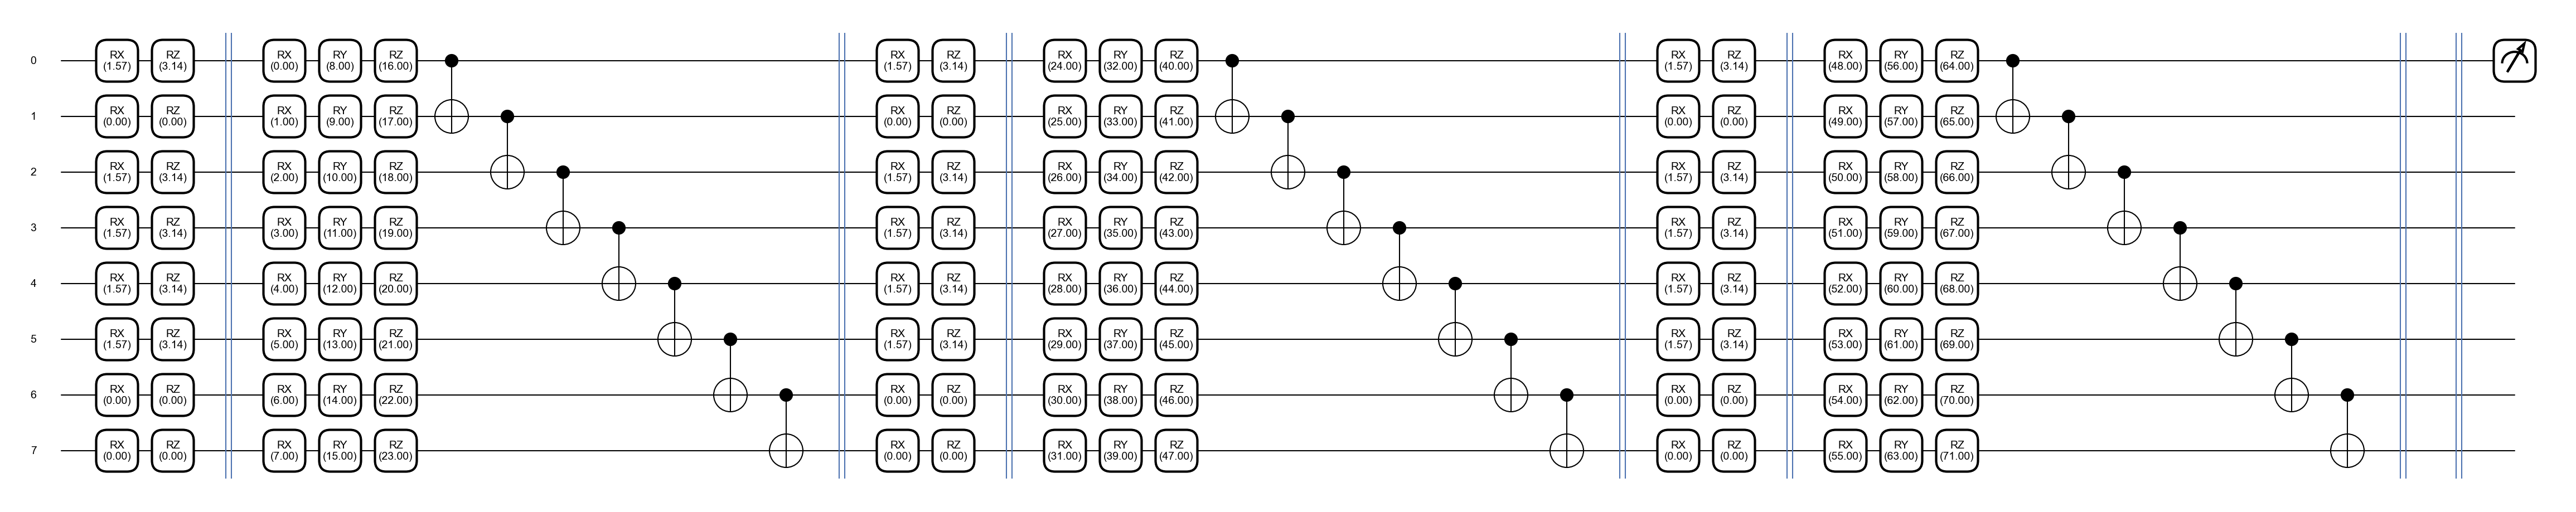

In [30]:
layers = 3
sublayers = 1
params_per_sublayer = 3*n_qubits
qml.draw_mpl(circuit_nonlinear, decimals=2,)([1,0,1,1,1,1,0,0],np.arange(params_per_sublayer*layers*sublayers))

## Circuit Training
This section takes care of training the QNN. The first section defines the cost, accuracy and optimizer update function. In particular:
- `calculate_mse_cost` - calculates the MSE cost
- `optimizer_update` - Uses the MSE cost to update the parameters in the model according to the chosen optimizer.

Following this the training is performed using a set number of epochs and stochastic steps per epoch which are defined by the user. Each training loop consists of the calculation of the cost and parameter update using `optimizer_update`, followed by saving the cost.

In [31]:
@jax.jit
def calculate_mse_cost(X, y, theta):
    '''
    X - Dataset
    y - The true label associated with X
    theta - Parameters of the QNN

    Calculates the MSE cost for a given data point and label.
    '''
    y = jnp.array(y)
    yp = qnn(X, theta) 
    cost = jnp.mean((yp - y) ** 2)#
    return cost

# @jax.jit
# def calculate_mse_cost_and_accuracy(X,y, theta,):
#     '''
#     X - input data
#     y - The true label associated with X
#     theta - Parameters of the QNN

#     Calculates both the MSE and the accuracy for a given data point
#     '''
#     y = jnp.array(y)
#     yp = qnn(X, theta) 
#     yp = jnp.array(yp)
#     cost = jnp.mean((yp - y) ** 2)
#     rounded = jnp.where(yp>0., 1, -1)
    
#     return cost, sum(rounded==y)/X.shape[0]

# Optimization update step
@jax.jit
def optimizer_update(opt_state, params, x, y, ):
    '''
    opt_state - state of the optimizer
    params - Parameters of the QNN
    x - input fetures
    y - The true label associated with X

    Calculates the MSE cost and updatez the parameters according to the chosen optimizer. 
    '''
    loss, grads = jax.value_and_grad(lambda theta: calculate_mse_cost(x, y, theta,))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [ ]:
#Parameter initialization
# n_runs = 1
epochs = 100 
batch_size = 30#
seed = 1234
min_layers, max_layers = 3,4
min_sublayers, max_sublayers = 2,2
for layers in range(min_layers, max_layers+1):
    for sublayers in range(min_sublayers, max_sublayers+1):

        #creating a folder to save data
        dir_path = '..'
        data = dir_path+f'/results/nonlinear/{layers}l-{sublayers}p' 
        os.makedirs(data,  0o755,  exist_ok=True)
        #Jax jit and vmap speed up the computational times of the circuit 
        
        params_per_sublayer = 3*n_qubits 
        qnn_batched = jax.vmap(circuit_nonlinear, (0, None,))
        qnn = jax.jit(qnn_batched)

        #Lists to save data 
        costs = []
        val_costs = []
        train_per_epoch = []
        val_per_epoch = []

        #Creating the initial random parameters for the QNN
        key = jax.random.PRNGKey(seed)
        initial_params = jax.random.normal(key, shape=((params_per_sublayer)*layers*sublayers,))
        key = jax.random.split(key)[0]
        params = jnp.copy(initial_params)

        #Optimizer initialization
        optimizer = optax.adam(learning_rate=0.01)
        opt_state = optimizer.init(initial_params)

        for epoch in range(epochs):
            # Generation of random indices to be used for batch
            idxs_dataset = jax.random.choice(key, jnp.array(list(range(X_train.shape[0]))), shape=(X_train.shape[0],), replace=False)
            key = jax.random.split(key)[0]
            for i in gen_batches(X_train.shape[0],batch_size):
                idxs = idxs_dataset[i]

                #Calculate cost function and update parameters accordingly
                params, opt_state, cost = optimizer_update(opt_state, params, X_train[idxs,:], y_train[idxs])

                #Save MSE Costs and accuracies for both train and validation dataset
                cost = calculate_mse_cost(X_train, y_train,params) #calculate_mse_cost_and_accuracy
                costs.append(cost)
                
                val_cost = calculate_mse_cost(X_valid, y_valid, params, ) #calculate_mse_cost_and_accuracy
                val_costs.append(val_cost)
            train_per_epoch.append(cost)
            val_per_epoch.append(val_cost)

            print(f"layers:{layers}, p:{sublayers}, epoch {epoch}/{epochs}",'--- Train cost:',cost,'--- Val cost:',val_cost, end='\r')

        
        np.save(data+'/train_cost.npy', list(costs))
        np.save(data+'/val_cost.npy', list(val_costs))
        np.save(data+'/train_cost_per_epoch.npy', list(train_per_epoch))
        np.save(data+'/val_cost_per_epoch.npy', list(val_per_epoch))
        np.save(data+'/opt_params.npy', list(params))


/var/folders/5_/kyjg8hpx2032cxxkfgxqk_sh0000gn/T/ipykernel_88705/3169912783.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', (max_layers-min_layers+1)*(max_sublayers-min_sublayers+1)+1)


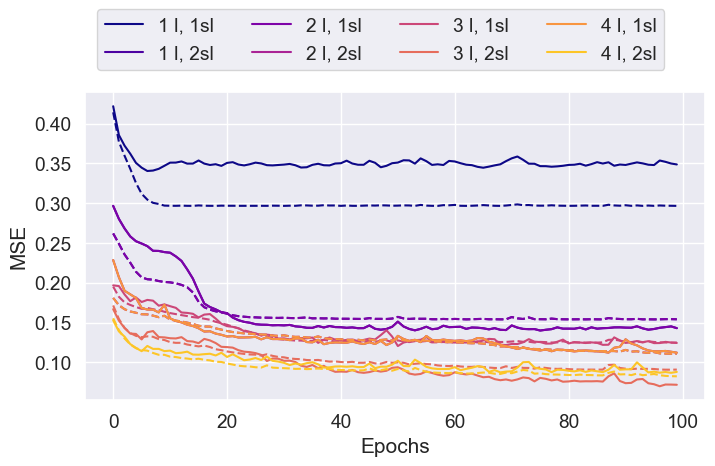

In [17]:
min_layers, max_layers = 1,4
min_sublayers, max_sublayers = 1,2

cmap = cm.get_cmap('plasma', (max_layers-min_layers+1)*(max_sublayers-min_sublayers+1)+1)

fig, ax = plt.subplots(figsize=(8,4))
# ax.set_ylim(0.1,1.65)

i = 0

for layers in range(min_layers, max_layers+1):
    for sublayers in range(min_sublayers, max_sublayers+1):
        
        dir_path = '..'

        data = dir_path+f'/results/nonlinear/{layers}l-{sublayers}p' 
        val_cost = np.load(data+'/val_cost_per_epoch.npy', )
        train_cost = np.load(data+'/train_cost_per_epoch.npy', )


        pl1, = ax.plot(train_cost,linestyle='dashed',# label=f'{layers} l, {sublayers}sl - Train', 
                 c=cmap(i),  )#alpha=0.5
        pl2, = ax.plot(val_cost, label=f'{layers} l, {sublayers}sl', 
                c=cmap(i))
        i+=1
        

ax.set_ylabel('MSE')
ax.set_xlabel('Epochs')
lgd = ax.legend(bbox_to_anchor=(.95, 1.3), ncol=4)#
# ax.add_artist(lgd)
# lgd1 = ax.legend([pl1,pl2],['Train','Val'], loc='lower left',bbox_to_anchor=(0.1, 0.3))#
# ax.add_artist(lgd)
#creating a folder to save the plot
dir_path = '..'
data = dir_path+f'/plots/nonlinear' 
os.makedirs(data,  0o755,  exist_ok=True)

fig.savefig(data+'/compare_mse_per_epoch.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

/var/folders/5_/kyjg8hpx2032cxxkfgxqk_sh0000gn/T/ipykernel_88705/216218381.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', (max_layers-min_layers+1)*(max_sublayers-min_sublayers+1)+1)


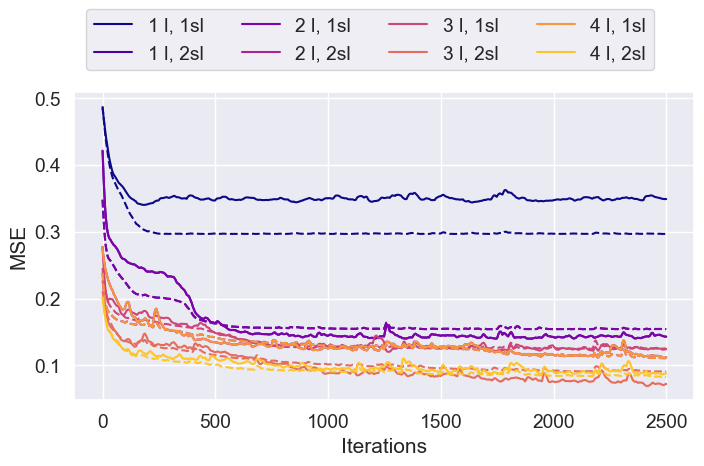

In [16]:
min_layers, max_layers = 1,4
min_sublayers, max_sublayers = 1,2

cmap = cm.get_cmap('plasma', (max_layers-min_layers+1)*(max_sublayers-min_sublayers+1)+1)

fig, ax = plt.subplots(figsize=(8,4))
# ax.set_ylim(0.1,1.65)

i = 0

for layers in range(min_layers, max_layers+1):
    for sublayers in range(min_sublayers, max_sublayers+1):
        
        dir_path = '..'

        data = dir_path+f'/results/nonlinear/{layers}l-{sublayers}p' 
        val_cost = np.load(data+'/val_cost.npy', )
        train_cost = np.load(data+'/train_cost.npy', )


        pl1, = ax.plot(train_cost,linestyle='dashed',# label=f'{layers} l, {sublayers}sl - Train', 
                 c=cmap(i),  )#alpha=0.5
        pl2, = ax.plot(val_cost, label=f'{layers} l, {sublayers}sl', 
                c=cmap(i))
        i+=1
        

ax.set_ylabel('MSE')
ax.set_xlabel('Iterations')
lgd = ax.legend(bbox_to_anchor=(.95, 1.3), ncol=4)#
# ax.add_artist(lgd)
# lgd1 = ax.legend([pl1,pl2],['Train','Val'], loc='lower left',bbox_to_anchor=(0.1, 0.3))#
# ax.add_artist(lgd)
#creating a folder to save the plot
dir_path = '..'
data = dir_path+f'/plots/nonlinear' 
os.makedirs(data,  0o755,  exist_ok=True)

fig.savefig(data+'/compare_mse.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Prediction

In [27]:
qnn_batched = jax.vmap(circuit_nonlinear, (0, None,))
qnn = jax.jit(qnn_batched)

dir_path = '..'
data = dir_path+f'/results/nonlinear/{layers}l-{sublayers}p' 
opt_params = np.load(data+'/opt_params.npy',)

calculate_mse_cost(X_test, y_test, opt_params)

NameError: name 'encode_data_linear' is not defined